

This notebook contains an example for teaching.


# A Simple Case Study using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [1]:
load("../../../data/wage2015_subsample_inference.Rdata")
dim(data)

[1] 5150   20

The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [2]:
Z <- subset(data,select=-c(lwage,wage)) # regressors
colnames(Z)

[1] "sex"  "shs"  "hsg"  "scl"  "clg"  "ad"   "mw"   "so"   "we"   "ne"  
[11] "exp1" "exp2" "exp3" "exp4" "occ"  "occ2" "ind"  "ind2"

The following figure shows the weekly wage distribution from the US survey data.

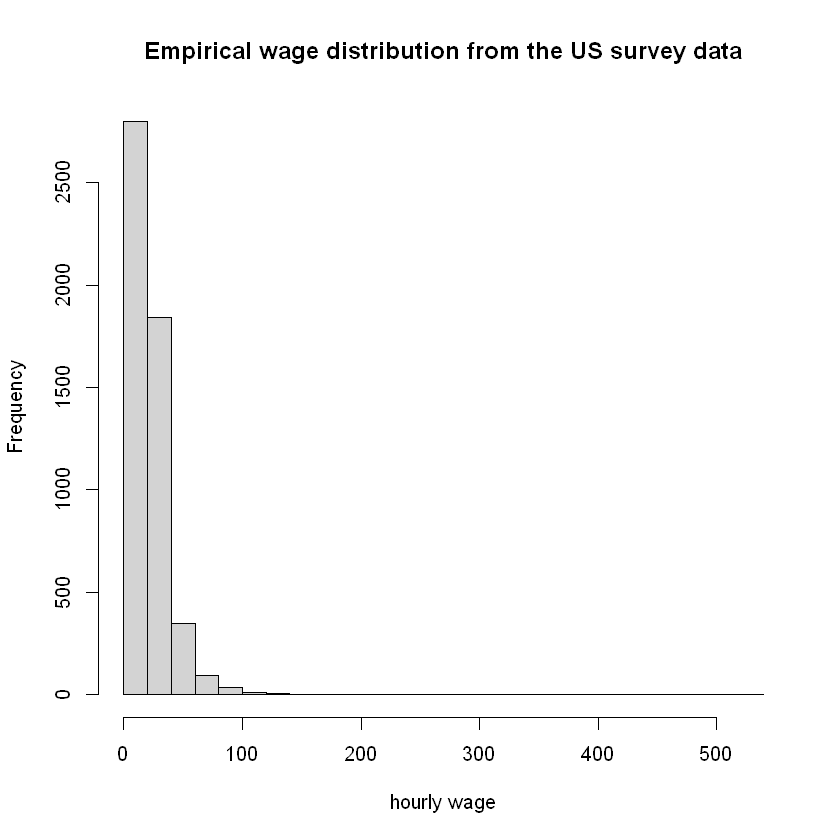

In [3]:
HV = hist(data$wage, xlab= "hourly wage", main="Empirical wage distribution from the US survey data", breaks= 35)

In [4]:
HV$breaks

[1]   0  20  40  60  80 100 120 140 160 180 200 220 240 260 280 300 320 340 360
[20] 380 400 420 440 460 480 500 520 540

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [5]:
set.seed(1234)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

data_train <- data[training,]
data_test <- data[-training,]

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [6]:
dim(data_test)

[1] 1288   20

In [7]:
dim(data_train)

[1] 3862   20

In [8]:
X_basic <-  "sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
X_flex <- "sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"
formula_basic <- as.formula(paste("lwage", "~", X_basic))
formula_flex <- as.formula(paste("lwage", "~", X_flex))

model_X_basic_train <- model.matrix(formula_basic,data_train)
model_X_basic_test <- model.matrix(formula_basic,data_test)
p_basic <- dim(model_X_basic_train)[2]

model_X_flex_train <- model.matrix(formula_flex,data_train)
model_X_flex_test <- model.matrix(formula_flex,data_test)
p_flex <- dim(model_X_flex_train)[2]

In [9]:
Y_train <- data_train$lwage
Y_test <- data_test$lwage

In [10]:
p_basic
p_flex

[1] 52

[1] 246

As known from our first lab, the basic model consists of $10$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [11]:
# ols (basic model)
fit.lm.basic <- lm(formula_basic, data_train)
fit.lm.basic


Call:
lm(formula = formula_basic, data = data_train)

Coefficients:
(Intercept)          sex         exp1         exp2          shs          hsg  
  3.6437477   -0.0717640    0.0257111   -0.0445318   -0.6721354   -0.5629813  
        scl          clg           mw           so           we        occ22  
 -0.4587648   -0.2162809   -0.0503536   -0.0463567   -0.0004436   -0.0802097  
      occ23        occ24        occ25        occ26        occ27        occ28  
 -0.0478553   -0.0771514   -0.1960378   -0.4145914   -0.0560435   -0.3982911  
      occ29       occ210       occ211       occ212       occ213       occ214  
 -0.2418527    0.0209148   -0.4141860   -0.2621792   -0.3483121   -0.4935402  
     occ215       occ216       occ217       occ218       occ219       occ220  
 -0.4671863   -0.2522700   -0.4000000   -0.1403810   -0.2313896   -0.1718888  
     occ221       occ222        ind23        ind24        ind25        ind26  
 -0.2600691   -0.4083185   -0.0678901   -0.2381938   -0.269454

In [12]:
# Compute the Out-Of-Sample Performance
yhat.lm.basic <- predict(fit.lm.basic, newdata=data_test)
cat("The mean squared error (MSE) using the basic model is equal to" , mean((Y_test-yhat.lm.basic)^2)) # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to 0.2293541

To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [13]:
MSE.lm.basic <- summary(lm((Y_test-yhat.lm.basic)^2~1))$coef[1:2]
MSE.lm.basic

[1] 0.22935406 0.01564666

We also compute the out-of-sample $R^2$:

In [14]:
R2.lm.basic <- 1-MSE.lm.basic[1]/var(Y_test)
cat("The R^2 using the basic model is equal to",R2.lm.basic) # MSE OLS (basic model) 

The R^2 using the basic model is equal to 0.2819899

We repeat the same procedure for the flexible model.

In [15]:
# ols (flexible model)
fit.lm.flex <- lm(formula_flex, data_train) 

# Compute the Out-Of-Sample Performance
options(warn=-1)
yhat.lm.flex <- predict(fit.lm.flex, newdata=data_test)
MSE.lm.flex <- summary(lm((Y_test-yhat.lm.flex)^2~1))$coef[1:2]

R2.lm.flex <- 1-MSE.lm.flex[1]/var(Y_test)
cat("The R^2 using the flexible model is equal to",R2.lm.flex) # MSE OLS (flexible model) 

The R^2 using the flexible model is equal to 0.2383204

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theoretical based choice of the penalty level $\lambda$ in the lasso regression.

In [16]:
#install.packages("hdm")

In [17]:
# lasso and versions
library(hdm) 
fit.rlasso  <- rlasso(formula_basic, data_train, post=FALSE)
fit.rlasso.post <- rlasso(formula_basic, data_train, post=TRUE)

yhat.rlasso   <- predict(fit.rlasso, newdata=data_test)
yhat.rlasso.post   <- predict(fit.rlasso.post, newdata=data_test)

MSE.lasso <- summary(lm((Y_test-yhat.rlasso)^2~1))$coef[1:2]
MSE.lasso.post <- summary(lm((Y_test-yhat.rlasso.post)^2~1))$coef[1:2]

R2.lasso <- 1-MSE.lasso[1]/var(Y_test)
R2.lasso.post <- 1-MSE.lasso.post[1]/var(Y_test)
cat("The R^2 using the basic model is equal to",R2.lasso,"for lasso and",R2.lasso.post,"for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2674345 for lasso and 0.2706874 for post-lasso

Now, we repeat the same procedure for the flexible model.

In [18]:
fit.rlasso.flex  <- rlasso(formula_flex, data_train, post=FALSE)
fit.rlasso.post.flex <- rlasso(formula_flex, data_train, post=TRUE)
yhat.rlasso.flex   <- predict(fit.rlasso.flex, newdata=data_test)
yhat.rlasso.post.flex   <- predict(fit.rlasso.post.flex, newdata=data_test)

MSE.lasso.flex <- summary(lm((Y_test-yhat.rlasso.flex)^2~1))$coef[1:2]
MSE.lasso.post.flex <- summary(lm((Y_test-yhat.rlasso.post.flex)^2~1))$coef[1:2]

R2.lasso.flex <- 1-MSE.lasso.flex[1]/var(Y_test)
R2.lasso.post.flex <- 1-MSE.lasso.post.flex[1]/var(Y_test)
cat("The R^2 using the flexible model is equal to",R2.lasso.flex,"for lasso and",R2.lasso.post.flex,"for post-lasso") # R^2 lasso/post-lasso (flexible model) 

The R^2 using the flexible model is equal to 0.2653058 for lasso and 0.2614714 for post-lasso

It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [19]:
library(glmnet)
fit.lasso.cv   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=1)
fit.ridge   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=0)
fit.elnet   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = model_X_basic_test)
yhat.ridge   <- predict(fit.ridge, newx = model_X_basic_test)
yhat.elnet   <- predict(fit.elnet, newx = model_X_basic_test)

MSE.lasso.cv <- summary(lm((Y_test-yhat.lasso.cv)^2~1))$coef[1:2]
MSE.ridge <- summary(lm((Y_test-yhat.ridge)^2~1))$coef[1:2]
MSE.elnet <- summary(lm((Y_test-yhat.elnet)^2~1))$coef[1:2]

R2.lasso.cv <- 1-MSE.lasso.cv[1]/var(Y_test)
R2.ridge <- 1-MSE.ridge[1]/var(Y_test)
R2.elnet <- 1-MSE.elnet[1]/var(Y_test)

# R^2 using cross-validation (basic model) 
cat("R^2 using cross-validation for lasso, ridge and elastic net in the basic model:",R2.lasso.cv,R2.ridge,R2.elnet)

Loading required package: Matrix

Loaded glmnet 4.1-4



R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.2824847 0.2669501 0.28039

Note that the following calculations for the flexible model need some computation time.

In [20]:
fit.lasso.cv.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=1)
fit.ridge.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=0)
fit.elnet.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv.flex    <- predict(fit.lasso.cv.flex , newx = model_X_flex_test)
yhat.ridge.flex    <- predict(fit.ridge.flex , newx = model_X_flex_test)
yhat.elnet.flex    <- predict(fit.elnet.flex , newx = model_X_flex_test)

MSE.lasso.cv.flex  <- summary(lm((Y_test-yhat.lasso.cv.flex )^2~1))$coef[1:2]
MSE.ridge.flex  <- summary(lm((Y_test-yhat.ridge.flex )^2~1))$coef[1:2]
MSE.elnet.flex  <- summary(lm((Y_test-yhat.elnet.flex )^2~1))$coef[1:2]

R2.lasso.cv.flex  <- 1-MSE.lasso.cv.flex [1]/var(Y_test)
R2.ridge.flex  <- 1-MSE.ridge.flex [1]/var(Y_test)
R2.elnet.flex  <- 1-MSE.elnet.flex [1]/var(Y_test)

# R^2 using cross-validation (flexible model) 
cat("R^2 using cross-validation for lasso, ridge and elastic net in the flexible model:",R2.lasso.cv.flex,R2.ridge.flex,R2.elnet.flex)

R^2 using cross-validation for lasso, ridge and elastic net in the flexible model: 0.2751157 0.2710676 0.2761405

In [21]:
MSE.lasso.cv.flex[1]
MSE.lasso.post.flex[1]

[1] 0.2315499

[1] 0.2359083

The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries

In [22]:
library(randomForest)
library(rpart)
library(nnet)
library(gbm)
library(rpart.plot)
library(keras)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8



In [23]:
#install.packages("randomForest")
#install.packages("gbm")
#install.packages("keras")

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [24]:
formula_basic

lwage ~ sex + exp1 + exp2 + shs + hsg + scl + clg + mw + so + 
    we + occ2 + ind2

cex 0.15   xlim c(0, 1)   ylim c(0, 1)


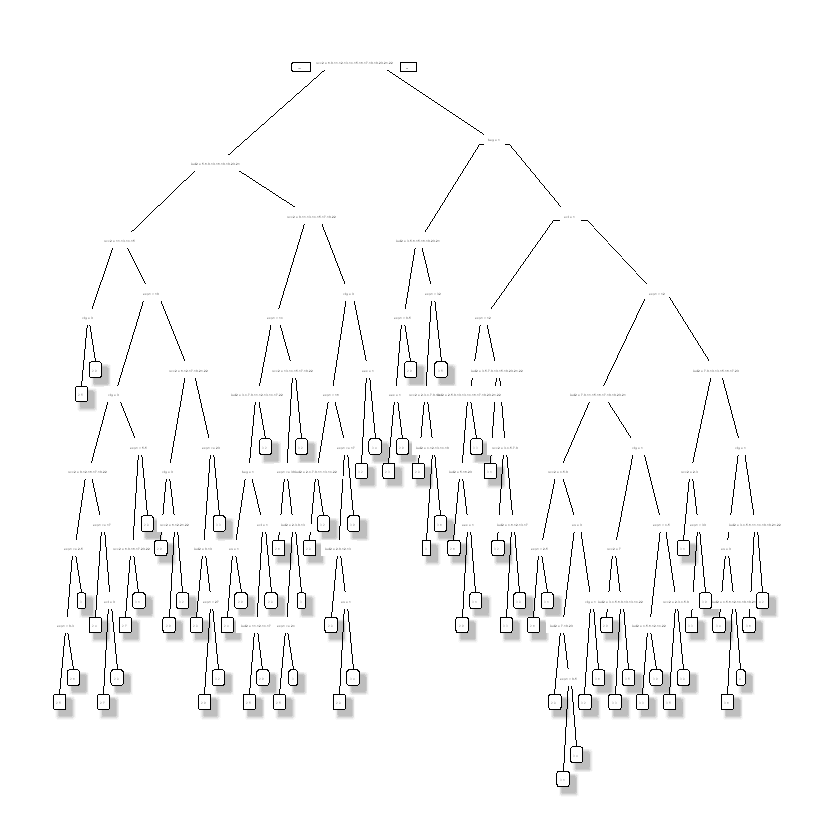

In [25]:
# tree
fit.trees <- rpart(formula_basic, data_train, cp = 0.001)
prp(fit.trees, leaf.round=1, space=2, yspace=2, split.space=2, shadow.col = "gray", trace = 1) # plotting the tree

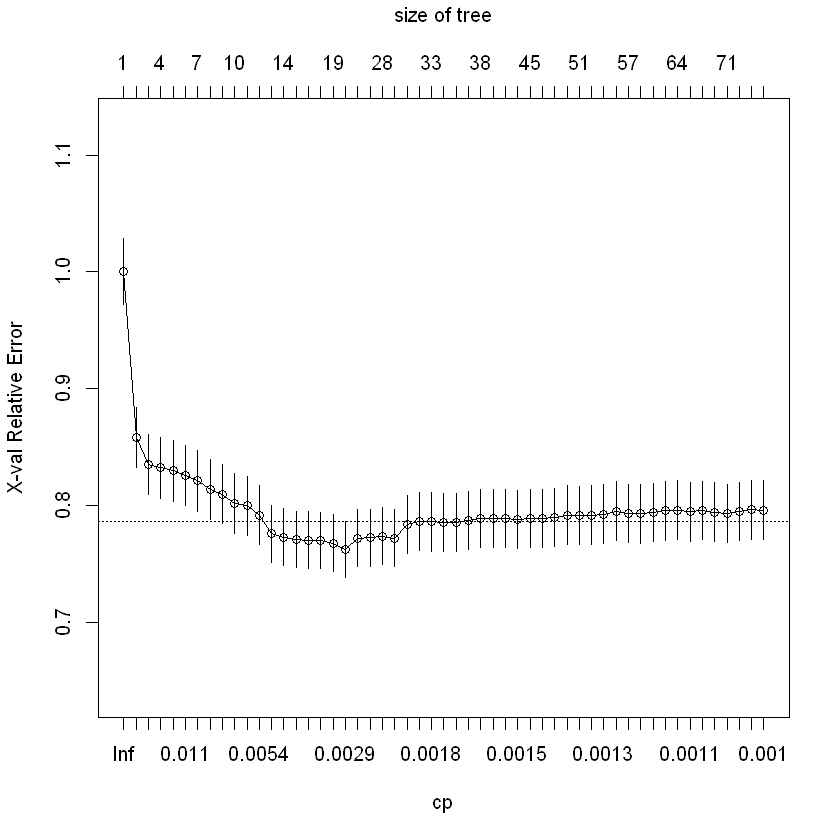

In [26]:
plotcp(fit.trees)

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [27]:
help(rpart.control)

In [28]:
fit.trees$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.143782671,0,1.0000000,1.0006385,0.02830985
2,0.033232401,1,0.8562173,0.8583545,0.02582850
3,0.013547061,2,0.8229849,0.8347385,0.02565099
4,0.013100098,3,0.8094379,0.8322688,0.02623596
5,0.012137010,4,0.7963378,0.8296152,0.02615622
6,0.010793911,5,0.7842008,0.8255968,0.02592291
7,0.010780955,6,0.7734068,0.8209575,0.02583769
8,0.007796456,7,0.7626259,0.8132921,0.02565316
9,0.007305074,8,0.7548294,0.8097419,0.02559565
10,0.006327716,9,0.7475244,0.8017226,0.02543792


In [29]:
which.min(fit.trees$cptable[,"xerror"])

19 
19

In [30]:
bestcp<- fit.trees$cptable[which.min(fit.trees$cptable[,"xerror"]),"CP"]
bestcp

[1] 0.002556354

Now, we can prune the tree and visualize the prediction rule.

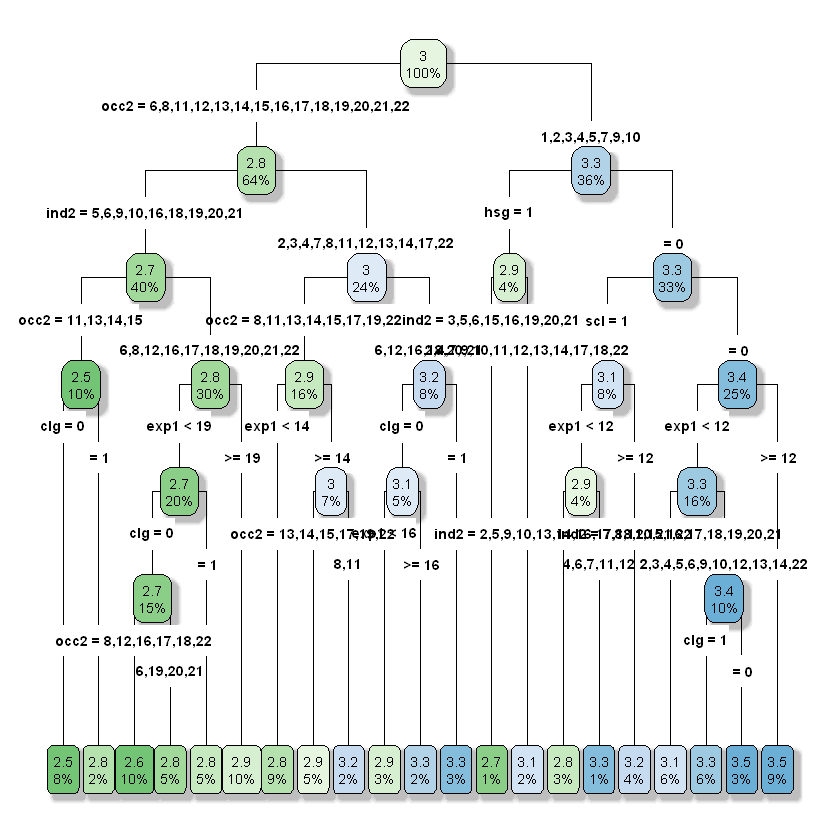

In [127]:
fit.prunedtree <- prune(fit.trees, cp=bestcp)
plot1 <- rpart.plot(fit.prunedtree,leaf.round=1, space=1, yspace=1.5, split.space=1, shadow.col = "gray", type =4,
          branch = 1, box.palette="GnBu", cex = 0.7)


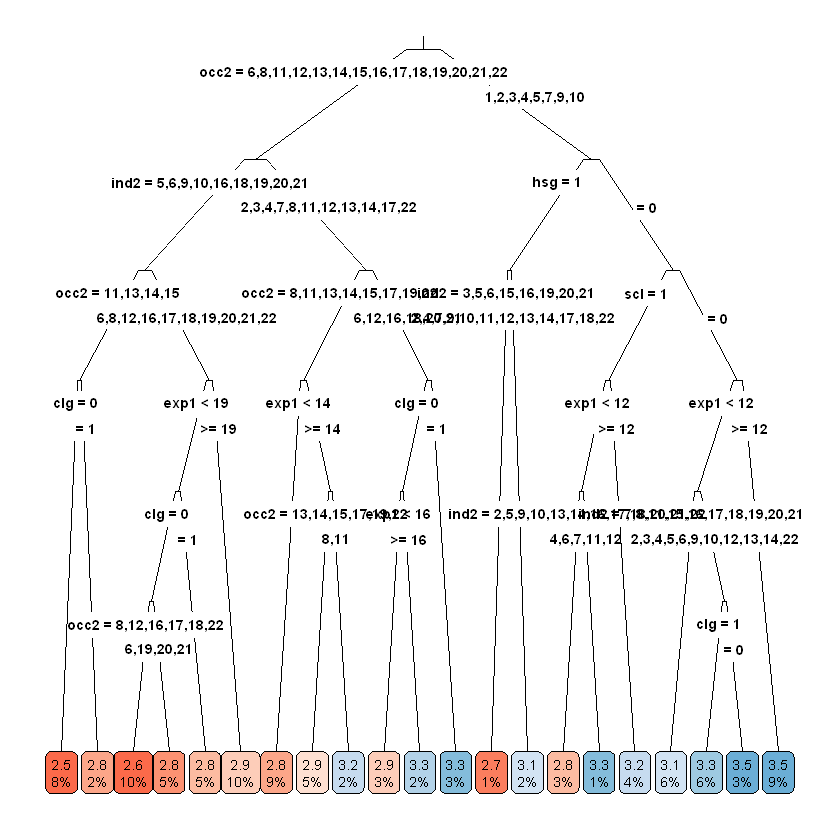

In [128]:
fit.prunedtree <- prune(fit.trees, cp=bestcp)
plot1 <- rpart.plot(fit.prunedtree,type =3, fallen = TRUE, leaf.round=1, extra = 100, branch = 0.1, box.palette="RdBu",cex = 0.7)

### Rpart.plot
http://www.milbo.org/rpart-plot/prp.pdf

In [32]:
fit.prunedtree

n= 3862 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 3862 1264.044000 2.969673  
    2) occ2=6,8,11,12,13,14,15,16,17,18,19,20,21,22 2454  653.735100 2.805353  
      4) ind2=5,6,9,10,16,18,19,20,21 1541  376.462800 2.704646  
        8) occ2=11,13,14,15 381   70.247020 2.540559  
         16) clg< 0.5 320   57.676610 2.495343 *
         17) clg>=0.5 61    8.484190 2.777755 *
        9) occ2=6,8,12,16,17,18,19,20,21,22 1160  292.588200 2.758540  
         18) exp1< 18.75 780  175.873000 2.694205  
           36) clg< 0.5 597  120.782600 2.656469  
             72) occ2=8,12,16,17,18,22 385   80.715230 2.591886 *
             73) occ2=6,19,20,21 212   35.545320 2.773754 *
           37) clg>=0.5 183   51.466780 2.817312 *
         19) exp1>=18.75 380  106.860100 2.890595 *
      5) ind2=2,3,4,7,8,11,12,13,14,17,22 913  235.265100 2.975330  
       10) occ2=8,11,13,14,15,17,19,22 613  137.072600 2.884646  
         20) exp1< 13.5 346   70.840230 2.784301 *
 

E.g., in the pruned tree the predicted hourly log wage for high-school graduates with more than $9.5$ years of experience is $2.8$, and otherwise is $2.6$.

Finally, we calculate the mean-squared error and the $R^2$ on the test sample to evaluate the out-of-sample performance of the pruned tree.

In [38]:
yhat.pt <- predict(fit.prunedtree,newdata=data_test)

MSE.pt <- summary(lm((Y_test-yhat.pt)^2~1))$coef[1:2]
R2.pt  <- 1-MSE.pt[1]/var(Y_test)

# R^2 of the pruned tree
cat("R^2 of the pruned tree:",R2.pt)

R^2 of the pruned tree: 0.224717

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods random forest and boosted trees.

In [39]:
## Applying the methods
# random forest
fit.rf       <- randomForest(formula_basic, ntree=2000, nodesize=5, data=data_train)
# for tuning: adjust input "mtry" to change the number of variables randomly sampled as candidates at each split

# boosting
fit.boost   <- gbm(formula_basic, data=data_train, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)
best.boost  <- gbm.perf(fit.boost, plot.it = FALSE) # cross-validation to determine when to stop

## Evaluating the methods
yhat.rf       <- predict(fit.rf, newdata=data_test) # prediction
yhat.boost    <- predict(fit.boost, newdata=data_test, n.trees=best.boost)

MSE.rf       = summary(lm((Y_test-yhat.rf)^2~1))$coef[1:2]
MSE.boost    = summary(lm((Y_test-yhat.boost)^2~1))$coef[1:2]
R2.rf  <- 1-MSE.rf[1]/var(Y_test)
R2.boost  <- 1-MSE.boost[1]/var(Y_test)

# printing R^2
cat("R^2 of the random forest and boosted trees:",R2.rf,R2.boost)


OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



R^2 of the random forest and boosted trees: 0.2684975 0.2758086

,var,rel.inf
,<chr>,<dbl>
occ2,occ2,49.0347054
ind2,ind2,25.4004324
exp1,exp1,8.5359444
hsg,hsg,7.3537886
scl,scl,5.5431048
shs,shs,2.3656004
sex,sex,0.8563958
clg,clg,0.4463901
mw,mw,0.2176123


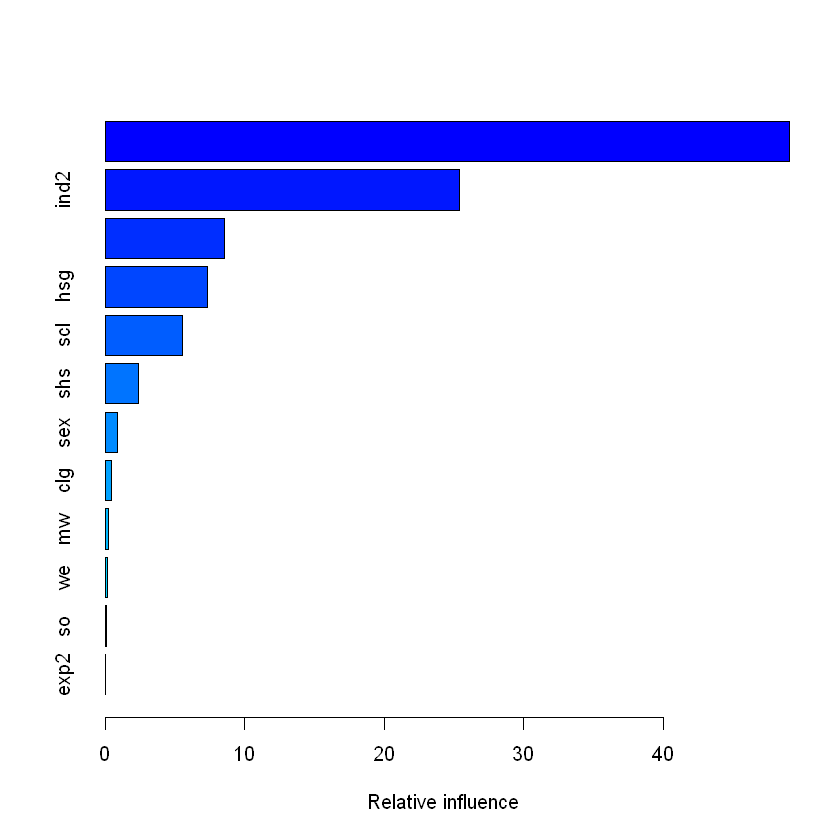

In [44]:
summary(fit.boost)

To conclude, let us have a look at our results.

## Results

In [60]:
library(xtable)
table<- matrix(0, 15, 3)
table[1,1:2]   <- MSE.lm.basic
table[2,1:2]   <- MSE.lm.flex
table[3,1:2]   <- MSE.lasso
table[4,1:2]   <- MSE.lasso.post
table[5,1:2]   <- MSE.lasso.flex
table[6,1:2]   <- MSE.lasso.post.flex
table[7,1:2]   <- MSE.lasso.cv
table[8,1:2]   <- MSE.ridge
table[9,1:2]   <- MSE.elnet
table[10,1:2]   <- MSE.lasso.cv.flex
table[11,1:2]  <- MSE.ridge.flex
table[12,1:2]  <- MSE.elnet.flex
table[13,1:2]  <- MSE.rf
table[14,1:2]  <- MSE.boost
table[15,1:2]  <- MSE.pt



table[1,3]   <- R2.lm.basic
table[2,3]   <- R2.lm.flex
table[3,3]   <- R2.lasso
table[4,3]   <- R2.lasso.post
table[5,3]   <- R2.lasso.flex
table[6,3]   <- R2.lasso.post.flex
table[7,3]   <- R2.lasso.cv
table[8,3]   <- R2.ridge
table[9,3]   <- R2.elnet
table[10,3]   <- R2.lasso.cv.flex
table[11,3]  <- R2.ridge.flex
table[12,3]  <- R2.elnet.flex
table[13,3]  <- R2.rf
table[14,3]  <- R2.boost
table[15,3]  <- R2.pt




colnames(table)<- c("MSE", "S.E. for MSE", "R-squared")
rownames(table)<- c("Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", 
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  
                    "Random Forest","Boosted Trees", "Pruned Tree")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab

% latex table generated in R 4.2.0 by xtable 1.8-4 package
% Mon May 30 22:14:28 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & MSE & S.E. for MSE & R-squared \\ 
  \hline
Least Squares (basic) & 0.229 & 0.016 & 0.282 \\ 
  Least Squares (flexible) & 0.243 & 0.016 & 0.238 \\ 
  Lasso & 0.234 & 0.015 & 0.267 \\ 
  Post-Lasso & 0.233 & 0.015 & 0.271 \\ 
  Lasso (flexible) & 0.235 & 0.015 & 0.265 \\ 
  Post-Lasso (flexible) & 0.236 & 0.016 & 0.261 \\ 
  Cross-Validated lasso & 0.229 & 0.015 & 0.282 \\ 
  Cross-Validated ridge & 0.234 & 0.015 & 0.267 \\ 
  Cross-Validated elnet & 0.230 & 0.015 & 0.280 \\ 
  Cross-Validated lasso (flexible) & 0.232 & 0.015 & 0.275 \\ 
  Cross-Validated ridge (flexible) & 0.233 & 0.015 & 0.271 \\ 
  Cross-Validated elnet (flexible) & 0.231 & 0.015 & 0.276 \\ 
  Random Forest & 0.233 & 0.015 & 0.270 \\ 
  Boosted Trees & 0.230 & 0.015 & 0.279 \\ 
  Pruned Tree & 0.248 & 0.016 & 0.224 \\ 
   \hline
\end{tabular}
\end{table}


,MSE,S.E. for MSE,R-squared
,<dbl>,<dbl>,<dbl>
Least Squares (basic),0.2293541,0.01564666,0.2819899
Least Squares (flexible),0.2433034,0.01582928,0.2383204
Lasso,0.2340035,0.01515122,0.2674345
Post-Lasso,0.2329644,0.01549996,0.2706874
Lasso (flexible),0.2346835,0.01512532,0.2653058
Post-Lasso (flexible),0.2359083,0.01560299,0.2614714
Cross-Validated lasso,0.2291960,0.01546289,0.2824847
Cross-Validated ridge,0.2341582,0.01534611,0.2669501
Cross-Validated elnet,0.2298651,0.01543630,0.2803900


Above, we displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$
in column 3. We see that the prediction rule produced by Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. It is worth to notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

### Ensemble learning

In the final step, we can build a prediction model by combing the strengths of the models we considered so far. This ensemble method is of the form
	$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest, Boosted Trees, and Neural Network and combine these methods into an ensemble method. The weights can be determined by a simple ols regression:

In [62]:
ensemble.ols <- summary(lm(Y_test~ yhat.lm.basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.ols


Call:
lm(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8520 -0.2848 -0.0067  0.2648  3.5151 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.16216    0.18693  -0.867 0.385835    
yhat.lm.basic          0.28137    0.14874   1.892 0.058755 .  
yhat.rlasso.post.flex  0.23709    0.17873   1.327 0.184904    
yhat.elnet.flex       -0.06780    0.28979  -0.234 0.815055    
yhat.pt               -0.13990    0.10440  -1.340 0.180496    
yhat.rf                0.37694    0.09861   3.823 0.000138 ***
yhat.boost             0.36707    0.18497   1.985 0.047412 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4735 on 1281 degrees of freedom
Multiple R-squared:  0.3013,	Adjusted R-squared:  0.298 
F-statistic: 92.07 on 6 and 1281 DF,  p-value: < 2.2e-16


Alternatively, we can determine the weights via lasso regression. 

In [63]:
ensemble.lasso <- summary(rlasso(Y_test~ yhat.lm.basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.lasso


Call:
rlasso.formula(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Post-Lasso Estimation:  TRUE 

Total number of variables: 6
Number of selected variables: 5 

Residuals: 
      Min        1Q    Median        3Q       Max 
-1.853465 -0.282571 -0.005527  0.263961  3.548724 

                      Estimate
(Intercept)             -0.147
yhat.lm.basic            0.293
yhat.rlasso.post.flex    0.223
yhat.elnet.flex         -0.056
yhat.pt                  0.000
yhat.rf                  0.344
yhat.boost               0.245

Residual standard error: 0.4728
Multiple R-squared:  0.3003
Adjusted R-squared:  0.2976
Joint significance test:
 the sup score statistic for joint significance test is  3.53 with a p-value of  0.04



Call:
rlasso.formula(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Coefficients:
          (Intercept)          yhat.lm.basic  yhat.rlasso.post.flex  
              -0.1469                 0.2931                 0.2229  
      yhat.elnet.flex                yhat.pt                yhat.rf  
              -0.0555                 0.0000                 0.3441  
           yhat.boost  
               0.2453  


The estimated weights are shown in the following table.

In [64]:
table<- matrix(0, 7, 2)
table[1:7,1]   <- ensemble.ols$coef[1:7]
table[1:7,2]   <- ensemble.lasso$coef[1:7]


colnames(table)<- c("Weight OLS", "Weight Lasso")
rownames(table)<- c("Constant","Least Squares (basic)","Post-Lasso (flexible)", "Cross-Validated elnet (flexible)", "Pruned Tree",
                    "Random Forest","Boosted Trees")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab

% latex table generated in R 4.2.0 by xtable 1.8-4 package
% Mon May 30 22:18:16 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Weight OLS & Weight Lasso \\ 
  \hline
Constant & -0.162 & -0.147 \\ 
  Least Squares (basic) & 0.281 & 0.293 \\ 
  Post-Lasso (flexible) & 0.237 & 0.223 \\ 
  Cross-Validated elnet (flexible) & -0.068 & -0.056 \\ 
  Pruned Tree & -0.140 & 0.000 \\ 
  Random Forest & 0.377 & 0.344 \\ 
  Boosted Trees & 0.367 & 0.245 \\ 
   \hline
\end{tabular}
\end{table}


,Weight OLS,Weight Lasso
,<dbl>,<dbl>
Constant,-0.16216323,-0.14687746
Least Squares (basic),0.28137447,0.29306223
Post-Lasso (flexible),0.23709009,0.22287842
Cross-Validated elnet (flexible),-0.06779791,-0.05550463
Pruned Tree,-0.13989808,0.00000000
Random Forest,0.37694246,0.34410087
Boosted Trees,0.36707275,0.24526815


Further, the $R^2$ for the test sample gets improved from $30\%$ obtained by OLS to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth to notice that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.